Comparisons of locomotion predictions of different mechanistic latent variable models.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats

from disp import set_plot


STRAIN_KEY = '_'.join(['NM91', 'ZH23']).lower()
REG_KEY = 'ridge_alpha_10'

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

MASKED = True

# Behavioral predictions from song features

In [2]:
FHEUR = f'data/simple/mlv/heuristic/heuristics_single_{STRAIN_KEY}_mtn_masked.npy'
data = np.load(FHEUR, allow_pickle=True)[0]

SONG_HEURS = [
    'N_S_ONSETS',
    'N_P_ONSETS',
    'N_B_ONSETS',
    'S_TOTAL',
    'P_TOTAL',
    'B_TOTAL',
    # duration/ratio vars are undefined at many timepoints, which significantly changes the dataset used for fitting
    'MN_S_DUR',
    'MN_P_DUR',  
    'MN_B_DUR',
#     'SP_RATIO',
]
# WDWS_HEUR = [1, 10, 30, 60, 120, 240, 480, 1800]
WDWS_HEUR = [1, 10, 30, 60, 120, 240, 480]

LABELS = [
    '# sine\nonsets',
    '# pulse\nonsets',
    '# bout\nonsets',
    
    'Total sine',
    'Total pulse',
    'Total song',
    
    'Mean sine\nduration',
    'Mean pulse\nduration',
    'Mean bout\nduration',
]

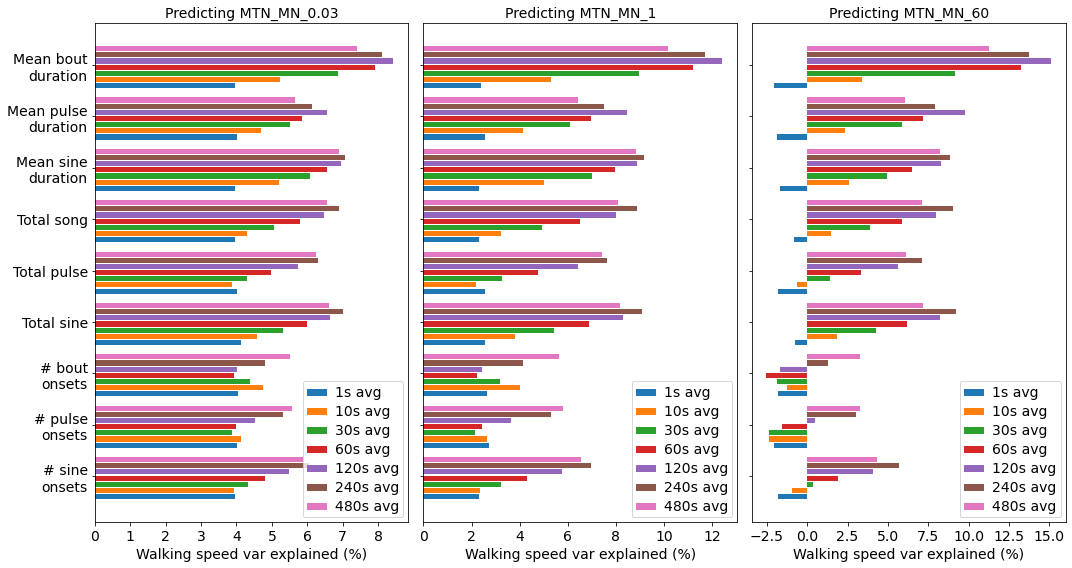

In [3]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(1, 3, figsize=(15, 8), tight_layout=True, sharey=True)

r2_heurs_all = {targ: [] for targ in TARGS}

for targ, ax in zip(TARGS, axs):
    r2_test_mn = data['r2_test'][targ].mean(axis=0)
    r2_test_std = data['r2_test'][targ].std(axis=0)
    r2_test_sem = r2_test_std / np.sqrt(data['r2_test'][targ].shape[0])
    
    y_ticks = []
    
    for cfeat, feat in enumerate(SONG_HEURS):
        for cwdw, (wdw, color) in enumerate(zip(WDWS_HEUR, colors)):
            
            icol = data['heurs'].index(f'{feat}_{wdw}')
            ax.barh(cfeat + .12*cwdw, 100*r2_test_mn[icol], height=.1, color=color)
            
            r2_heurs_all[targ].append(data['r2_test'][targ][:, icol])
        
        y_ticks.append(cfeat+ .4)
        
        
    ax.legend([f'{wdw}s avg' for wdw in WDWS_HEUR])
    
    set_plot(ax, y_ticks=y_ticks, y_tick_labels=LABELS, x_label=r'Walking speed var explained (%)', title=f'Predicting {targ}', font_size=14)
    
fig.savefig('supp/15_fmtn_from_song_feats.svg')

In [4]:
r2_heur_imaxs = {targ: np.argmax(np.array(r2_heurs_all[targ]).mean(axis=1)) for targ in TARGS}
r2_heur_maxs = {targ: np.array(r2_heurs_all[targ]).T[:, r2_heur_imax] for targ, r2_heur_imax in r2_heur_imaxs.items()}

## Best reservoir network prediction

In [5]:
LOAD_DIR = 'data/simple/mlv/rsvr'
PFX_RSVR = 'rsvr'

fnames = [fname for fname in os.listdir(LOAD_DIR) if fname.startswith(PFX_RSVR)]

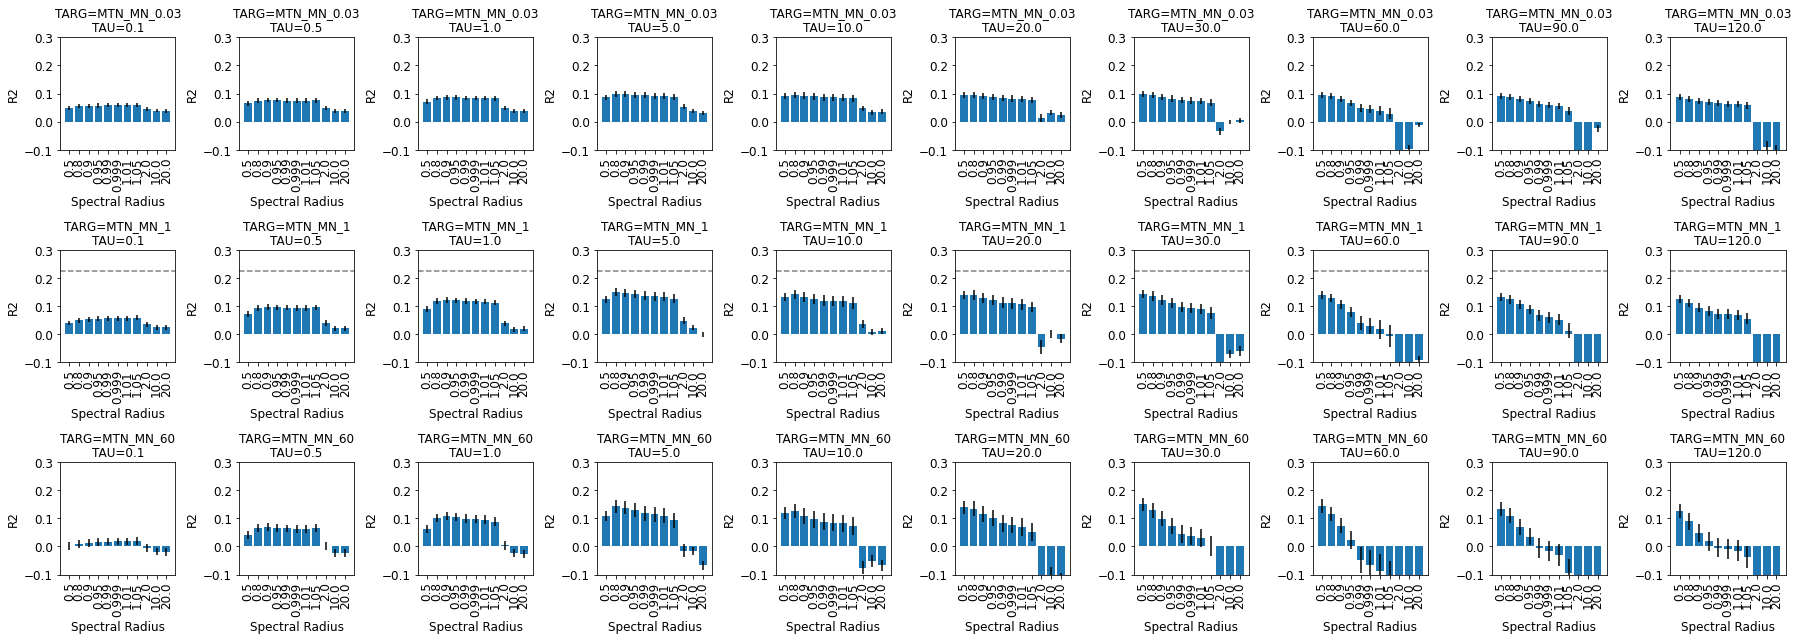

In [8]:
r2_test_mn_rsvrs = {targ: [] for targ in TARGS}
r2_test_sem_rsvrs = {targ: [] for targ in TARGS}

taus = []
radii = []

for fname in fnames:
    
    data = np.load(os.path.join(LOAD_DIR, fname), allow_pickle=True)[0]
    
    r2_trains = data['R2_TRAINS']
    r2_tests = data['R2_TESTS']
    
    radius = data['RADIUS']
    tau = data['TAU']
    
    for targ in TARGS:
        r2_test_mn_rsvrs[targ].append(np.mean(r2_tests[targ]))
        r2_test_sem_rsvrs[targ].append(stats.sem(r2_tests[targ]))
    
    taus.append(tau)
    radii.append(radius)
    
fig, axs = plt.subplots(3, len(np.unique(taus)), figsize=(25, 9), tight_layout=True)
for tau, ax_col in zip(sorted(np.unique(taus)), axs.T):
    iruns = (np.array(taus) == tau)
    radii_ = np.array(radii)[iruns]
    r2_test_mns_ = {targ: np.array(r2_test_mn_rsvrs[targ])[iruns] for targ in TARGS}
    r2_test_sems_ = {targ: np.array(r2_test_sem_rsvrs[targ])[iruns] for targ in TARGS}
    
    for targ, ax in zip(TARGS, ax_col):
        ax.bar(
            np.arange(len(radii_)),
            r2_test_mns_[targ][np.argsort(radii_)],
            yerr=r2_test_sems_[targ][np.argsort(radii_)]
        )
        
        if targ == 'MTN_MN_1':
            ax.axhline(.225, color='gray', ls='--')
            
        set_plot(
            ax, x_ticks=range(len(radii_)), y_lim=(-.1, .3),
            x_label='Spectral Radius', y_label='R2', title=f'TARG={targ}\nTAU={tau}')
        
        ax.set_xticklabels(sorted(radii_), rotation=90)

In [7]:
r2_rsvr_imaxs = {targ: np.argmax(r2_test_mn_rsvrs[targ]) for targ in TARGS}
r2_rsvr_mn_maxs = {targ: r2_test_mn_rsvrs[targ][r2_rsvr_imax] for targ, r2_rsvr_imax in r2_rsvr_imaxs.items()}
r2_rsvr_sem_maxs = {targ: r2_test_sem_rsvrs[targ][r2_rsvr_imax] for targ, r2_rsvr_imax in r2_rsvr_imaxs.items()} 

# Basic comparison of single vs population fits using different neural models.

In [8]:
NNRN = 224
NRL_MDLS = [
    'linma',  # linear neural model w MA-derived filters
    # 'lnma',  # lin-nonlin neural model w MA-derived filters
    'lnma_tweaked',  # lin-nonlin neural model w double-exp filter optimized from MA fit
    'ma',  # mult-adapt neural model
    
#     'lnr',  # linear-nonlinear model (fit w ridge regr)
#     'lnr_relu',  
#     'lnr_relu_flex',
    
    
#     'linr',  # linear neural model (fit w ridge regr)
    
#     'ma_ind_ta',
    
#     'lin',  # linear neural model
#     'ln',  # linear-nonlinear model
]

LABELS = {
    'ma': 'MA',
    # 'lnma': 'LN',
#     'lnr': 'LN-R',
#     'lnr_relu_flex': 'LN_FLEX',
    'lnma_tweaked': 'LN',
    
    'linma': 'Lin',
    
#     'ma_ind_ta': 'MA_IND_TA',
    
    'MTN': 'Motion',
}

In [9]:
if not MASKED:
    # heuristic predictors
    time_rslt = np.load(f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]

    # linear fits
    lin_rslt = np.load(f'data/simple/mlv/lin_filter/rc_lin_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]

    # single-neuorn fits
    single_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # ppln fits
    ppln_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # shuffled MA fit
    shfl_rslt = np.load(f'data/simple/mlv/ma_shfl/baker_ma_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]
    
else:
    # heuristic predictors
    time_rslt = np.load(f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{TARG_BHV.lower()}_masked.npy', allow_pickle=True)[0]

    # linear fits
    lin_rslt = np.load(f'data/simple/mlv/lin_filter/rc_lin_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]

    # single-neuorn fits
    single_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}_masked.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # ppln fits
    ppln_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # shuffled MA fit
    shfl_rslt = np.load(f'data/simple/mlv/ma_shfl/baker_ma_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]

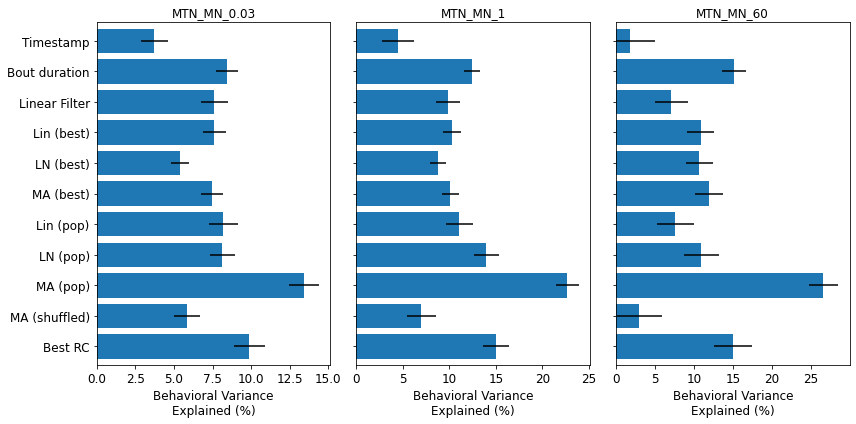

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), tight_layout=True)
                
ma_ppln_r2s = {}

for ax, twdw in zip(axs, TWDWS):
    labels = []
    r2_mns = []
    r2_sems = []
    
    targ = f'{TARG_BHV}_MN_{twdw}'
    
    # heuristics
    labels.append('Timestamp')
    r2_mns.append(time_rslt['r2_test'][targ].mean())
    r2_sems.append(time_rslt['r2_test'][targ].std() / np.sqrt(time_rslt['nsplit']))
    
    labels.append('Bout duration')
    r2_mns.append(r2_heur_maxs[targ].mean())
    r2_sems.append(r2_heur_maxs[targ].std() / np.sqrt(len(r2_heur_maxs[targ])))
    
    # linear fits
    labels.append('Linear Filter')
    r2_mns.append(lin_rslt['r2_test'][targ].mean())
    r2_sems.append(lin_rslt['r2_test'][targ].std() / np.sqrt(lin_rslt['nsplit']))
    
    # single neuron results
    for nrl_mdl, single_rslt in zip(NRL_MDLS, single_rslts):
        r2_maxs = single_rslt['r2_test'][targ].max(axis=1)
        labels.append(f'{LABELS[nrl_mdl]} (best)')
        r2_mns.append(r2_maxs.mean())
        r2_sems.append(r2_maxs.std() / np.sqrt(len(r2_maxs)))
        
    # ppln results
    for nrl_mdl, ppln_rslt in zip(NRL_MDLS, ppln_rslts):
        labels.append(f'{LABELS[nrl_mdl]} (pop)')
        r2_mns.append(ppln_rslt['r2_test'][targ].mean())
        r2_sems.append(ppln_rslt['r2_test'][targ].std() / np.sqrt(ppln_rslt['nsplit']))
        
        if nrl_mdl == 'ma':
            ma_ppln_r2s[targ] = ppln_rslt['r2_test'][targ].mean()
        
    # shuffled MA fit
    labels.append('MA (shuffled)')
    r2_mns.append(shfl_rslt['r2_test'][targ].mean())
    r2_sems.append(shfl_rslt['r2_test'][targ].std() / np.sqrt(shfl_rslt['nshfl']))
        
    # reservoir network fit
    labels.append('Best RC')
    r2_mns.append(r2_rsvr_mn_maxs[targ])
    r2_sems.append(r2_rsvr_sem_maxs[targ])
    
    r2_mns = np.array(r2_mns)
    r2_sems = np.array(r2_sems)
    
    ax.barh(np.arange(len(r2_mns)), 100*r2_mns, xerr=100*r2_sems)
    ax.set_xlim(left=0)
    
    ax.set_yticks(np.arange(len(labels)))
    ax.set_ylim(len(r2_mns)-.4, -.6)
    if ax is axs[0]:
        ax.set_yticklabels(labels)
    else:
        ax.set_yticklabels([])
        
    set_plot(ax, x_label='Behavioral Variance\nExplained (%)', title=targ, font_size=12)

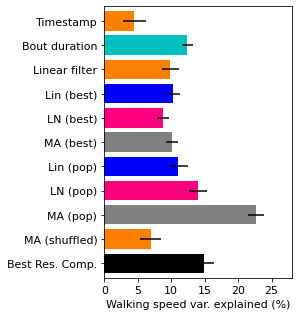

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 4.5), tight_layout=True)
                
colors_all = {
    'Timestamp': (1, .5, 0),
    'Bout duration': (0, .75, .75),
    'Linear filter': (1, .5, 0),
    'Lin (best)': (0, 0, 1),
    'LN (best)': (1, 0, .5), 
    'MA (best)': (.5, .5, .5),
    'Lin (pop)': (0, 0, 1),
    'LN (pop)': (1, 0, .5), 
    'MA (pop)': (.5, .5, .5),
    'MA (shuffled)': (1, .5, 0),
    'Best Res. Comp.': (0, 0, 0),
}

for ctwdw, twdw in enumerate(TWDWS[1:]):
    labels = []
    r2_mns = []
    r2_sems = []
    
    targ = f'{TARG_BHV}_MN_{twdw}'
    
    # heuristics
    labels.append('Timestamp')
    r2_mns.append(time_rslt['r2_test'][targ].mean())
    r2_sems.append(time_rslt['r2_test'][targ].std() / np.sqrt(time_rslt['nsplit']))
    
    # song features
    labels.append('Bout duration')
    r2_mns.append(r2_heur_maxs[targ].mean())
    r2_sems.append(r2_heur_maxs[targ].std() / np.sqrt(len(r2_heur_maxs[targ])))
    
    # linear fits
    labels.append('Linear filter')
    r2_mns.append(lin_rslt['r2_test'][targ].mean())
    r2_sems.append(lin_rslt['r2_test'][targ].std() / np.sqrt(lin_rslt['nsplit']))
    
    # single neuron results
    for nrl_mdl, single_rslt in zip(NRL_MDLS, single_rslts):
        r2_maxs = single_rslt['r2_test'][targ].max(axis=1)
        labels.append(f'{LABELS[nrl_mdl]} (best)')
        r2_mns.append(r2_maxs.mean())
        r2_sems.append(r2_maxs.std() / np.sqrt(len(r2_maxs)))
        
    # ppln results
    for nrl_mdl, ppln_rslt in zip(NRL_MDLS, ppln_rslts):
        labels.append(f'{LABELS[nrl_mdl]} (pop)')
        r2_mns.append(ppln_rslt['r2_test'][targ].mean())
        r2_sems.append(ppln_rslt['r2_test'][targ].std() / np.sqrt(ppln_rslt['nsplit']))
        
    # shuffled MA fit
    labels.append('MA (shuffled)')
    r2_mns.append(shfl_rslt['r2_test'][targ].mean())
    r2_sems.append(shfl_rslt['r2_test'][targ].std() / np.sqrt(shfl_rslt['nshfl']))
        
    # reservoir network fit
    labels.append('Best Res. Comp.')
    r2_mns.append(r2_rsvr_mn_maxs[targ])
    r2_sems.append(r2_rsvr_sem_maxs[targ])
    
    r2_mns = np.array(r2_mns)
    r2_sems = np.array(r2_sems)
    
    if ctwdw == 0:
        colors = [np.array(colors_all[label]) for label in labels]
        ax.barh(np.arange(len(r2_mns)), 100*r2_mns, xerr=100*r2_sems, height=-.8, align='center', color=colors)
    else:
        # pass
        colors = [.7*np.array(colors_all[label]) for label in labels]
        # ax.barh(np.arange(len(r2_mns)), 100*r2_mns, xerr=100*r2_sems, height=.4, align='edge', color=colors)
        
    ax.set_xlim(right=28)
    
    ax.set_yticks(np.arange(len(labels)))
    ax.set_ylim(len(r2_mns)-.4, -.6)
    ax.set_yticklabels(labels)
        
    set_plot(ax, x_label='Walking speed var. explained (%)', font_size=11)
    
fig.savefig('ms/fig_1g.svg')

In [12]:
# compute P-values
ppln_rslt_dict = {nrl_mdl: ppln_rslt for nrl_mdl, ppln_rslt in zip(NRL_MDLS, ppln_rslts)}


for twdw in TWDWS:
    targ = f'{TARG_BHV}_MN_{twdw}'
    print(f'TARG: {targ}:')
    
    ## Bout dur vs MA
    t_stat, p_val = stats.ttest_ind(r2_heur_maxs[targ], ppln_rslt_dict['ma']['r2_test'][targ])
    print(f'Bout dur vs MA: P = {p_val}')
    
    ## Lin vs MA
    t_stat, p_val = stats.ttest_ind(ppln_rslt_dict['linma']['r2_test'][targ], ppln_rslt_dict['ma']['r2_test'][targ])
    print(f'Lin vs MA: P = {p_val}')
    
    ## LN vs MA
    t_stat, p_val = stats.ttest_ind(ppln_rslt_dict['lnma_tweaked']['r2_test'][targ], ppln_rslt_dict['ma']['r2_test'][targ])
    print(f'LN vs MA: P = {p_val}')
    
    ## MA vs best res comp
    data_rsvr = np.load(os.path.join(LOAD_DIR, fnames[r2_rsvr_imaxs[targ]]), allow_pickle=True)[0]
    
    t_stat, p_val = stats.ttest_ind(data_rsvr['R2_TESTS'][targ], ppln_rslt_dict['ma']['r2_test'][targ])
    print(f'RC vs MA: P = {p_val}')

TARG: MTN_MN_0.03:
Bout dur vs MA: P = 0.0001389378602795084
Lin vs MA: P = 0.0003727738520642849
LN vs MA: P = 0.00014810899801545092
RC vs MA: P = 0.01460408528211489
TARG: MTN_MN_1:
Bout dur vs MA: P = 9.150307898373498e-09
Lin vs MA: P = 1.408553552721597e-07
LN vs MA: P = 1.6883117723298314e-05
RC vs MA: P = 0.00012834173577668982
TARG: MTN_MN_60:
Bout dur vs MA: P = 2.251669489395808e-05
Lin vs MA: P = 6.400083065364831e-08
LN vs MA: P = 2.512508730513827e-06
RC vs MA: P = 0.00041474511278405873


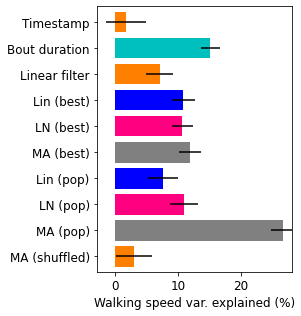

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 4.5), tight_layout=True)
                
colors_all = {
    'Timestamp': (1, .5, 0),
    'Bout duration': (0, .75, .75),
    'Linear filter': (1, .5, 0),
    'Lin (best)': (0, 0, 1),
    'LN (best)': (1, 0, .5), 
    'MA (best)': (.5, .5, .5),
    'Lin (pop)': (0, 0, 1),
    'LN (pop)': (1, 0, .5), 
    'MA (pop)': (.5, .5, .5),
    'MA (shuffled)': (1, .5, 0),
}

for ctwdw, twdw in enumerate(TWDWS[2:]):
    labels = []
    r2_mns = []
    r2_sems = []
    
    targ = f'{TARG_BHV}_MN_{twdw}'
    
    # heuristics
    labels.append('Timestamp')
    r2_mns.append(time_rslt['r2_test'][targ].mean())
    r2_sems.append(time_rslt['r2_test'][targ].std() / np.sqrt(time_rslt['nsplit']))
    
    # song features
    labels.append('Bout duration')
    r2_mns.append(r2_heur_maxs[targ].mean())
    r2_sems.append(r2_heur_maxs[targ].std() / np.sqrt(len(r2_heur_maxs[targ])))
    
    # linear fits
    labels.append('Linear filter')
    r2_mns.append(lin_rslt['r2_test'][targ].mean())
    r2_sems.append(lin_rslt['r2_test'][targ].std() / np.sqrt(lin_rslt['nsplit']))
    
    # single neuron results
    for nrl_mdl, single_rslt in zip(NRL_MDLS, single_rslts):
        r2_maxs = single_rslt['r2_test'][targ].max(axis=1)
        labels.append(f'{LABELS[nrl_mdl]} (best)')
        r2_mns.append(r2_maxs.mean())
        r2_sems.append(r2_maxs.std() / np.sqrt(len(r2_maxs)))
        
    # ppln results
    for nrl_mdl, ppln_rslt in zip(NRL_MDLS, ppln_rslts):
        labels.append(f'{LABELS[nrl_mdl]} (pop)')
        r2_mns.append(ppln_rslt['r2_test'][targ].mean())
        r2_sems.append(ppln_rslt['r2_test'][targ].std() / np.sqrt(ppln_rslt['nsplit']))
        
    # shuffled MA fit
    labels.append('MA (shuffled)')
    r2_mns.append(shfl_rslt['r2_test'][targ].mean())
    r2_sems.append(shfl_rslt['r2_test'][targ].std() / np.sqrt(shfl_rslt['nshfl']))
        
    r2_mns = np.array(r2_mns)
    r2_sems = np.array(r2_sems)
    
    if ctwdw == 0:
        colors = [np.array(colors_all[label]) for label in labels]
        ax.barh(np.arange(len(r2_mns)), 100*r2_mns, xerr=100*r2_sems, height=-.8, align='center', color=colors)
    else:
        # pass
        colors = [.7*np.array(colors_all[label]) for label in labels]
        # ax.barh(np.arange(len(r2_mns)), 100*r2_mns, xerr=100*r2_sems, height=.4, align='edge', color=colors)
        
    ax.set_xlim(right=28)
    
    ax.set_yticks(np.arange(len(labels)))
    ax.set_ylim(len(r2_mns)-.4, -.6)
    ax.set_yticklabels(labels)
        
    set_plot(ax, x_label='Walking speed var. explained (%)', font_size=12)
    
fig.savefig('supp/8_var_xpl_1_min.svg')

# Behavioral predictions from perturbed surrogate population recordings

In [11]:
KBHVS_FOLDERS_KEYS = [
    ('ma', 'neur_basic', 'Full MA pop.'),
    (None, None, None),
    ('ma_no_sel', 'ma_pert', 'No selectivity'),
    ('ma_pure_sel', 'ma_pert', 'Pure selectivity'),
    ('ma_sine_sel', 'ma_pert', 'Sine selective'),
    ('ma_pulse_sel', 'ma_pert', 'Pulse selective'),
    (None, None, None),
    ('ma_sia', 'neur_basic', 'Stim-inv adapt.'),
    ('ma_no_adapt', 'ma_pert', 'No adaptation'),
#     ('masrb', 'neur_basic', 'MA Sine-Rebound'),
    (None, None, None),
    ('ma_fast_r_fast_a', 'ma_pert', r'Fast $\tau_r$, fast $\tau_a$'),
    ('ma_fast_r_med_a', 'ma_pert', r'Fast $\tau_r$, med $\tau_a$'),
    ('ma_fast_r_slow_a', 'ma_pert', r'Fast $\tau_r$, slow $\tau_a$'),
    (None, None, None),
    ('ma_med_r_fast_a', 'ma_pert', r'Med. $\tau_r$, fast $\tau_a$'),
    ('ma_med_r_med_a', 'ma_pert', r'Med. $\tau_r$, med $\tau_a$'),
    ('ma_med_r_slow_a', 'ma_pert', r'Med. $\tau_r$, slow $\tau_a$'),
    (None, None, None),
    ('ma_slow_r_fast_a', 'ma_pert', r'Slow $\tau_r$, fast $\tau_a$'),
    ('ma_slow_r_med_a', 'ma_pert', r'Slow $\tau_r$, med $\tau_a$'),
    ('ma_slow_r_slow_a', 'ma_pert', r'Slow $\tau_r$, slow $\tau_a$'),
]

rslts_1 = []
rslts_60 = []

for kbhv, folder, key in KBHVS_FOLDERS_KEYS:
    if folder is not None:
        if not MASKED:
            fit_data = np.load(f'data/simple/mlv/{folder}/baker_{kbhv}_nm91_zh23_mtn_ridge_alpha_10.npy', allow_pickle=True)[0]
        else:
            fit_data = np.load(f'data/simple/mlv/{folder}/baker_{kbhv}_nm91_zh23_mtn_ridge_alpha_10_masked.npy', allow_pickle=True)[0]

        nsplit = len(fit_data['r2_test']['MTN_MN_60'])

        r2_1 = fit_data['r2_test']['MTN_MN_1'].mean()
        err_1 = fit_data['r2_test']['MTN_MN_1'].std()/np.sqrt(nsplit)
        
        r2_60 = fit_data['r2_test']['MTN_MN_60'].mean()
        err_60 = fit_data['r2_test']['MTN_MN_60'].std()/np.sqrt(nsplit)
    else:
        r2_1 = np.nan
        err_1 = np.nan
        r2_60 = np.nan
        err_60 = np.nan
    
    rslts_1.append((key, r2_1, err_1))
    rslts_60.append((key, r2_60, err_60))

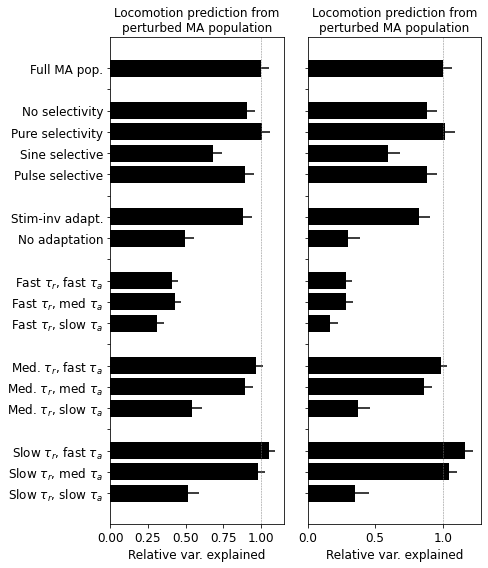

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(7, 8), tight_layout=True, sharey=True)
for crslts, (ax, rslts) in enumerate(zip(axs, [rslts_1, rslts_60])):
    max_r2 = rslts[0][1]
    
    for crslt, (key, r2, err) in enumerate(rslts):
        ax.barh([-crslt], [r2/max_r2], xerr=[err/max_r2], color='k')
        
    ax.axvline(1, color='gray', ls='--', lw=.5)

    ax.set_yticks(-np.arange(len(rslts)))
    ax.set_yticklabels([rslt[0] for rslt in rslts])

    set_plot(ax, x_label='Relative var. explained', title='Locomotion prediction from\nperturbed MA population', font_size=12)
    
fig.savefig('ms/fig_2a.svg')

# Behavioral predictions from other neural models

In [13]:
KBHVS_FOLDERS_KEYS = [
    ('ma', 'neur_basic', 'Full MA pop.'),
    ('lnr_relu', 'neur_basic', 'LN RELU'),
    ('lnr_relu_flex', 'neur_basic', 'LN RELU-FLEX'),
    (None, None, None),
    ('masrb', 'neur_basic', 'MA Sine-Rebound'),
    ('masrb_pq', 'neur_basic', 'MA Sine-Rebound*'),
]

rslts_1 = []
rslts_60 = []

for kbhv, folder, key in KBHVS_FOLDERS_KEYS:
    if folder is not None:
        if not MASKED:
            fit_data = np.load(f'data/simple/mlv/{folder}/baker_{kbhv}_nm91_zh23_mtn_ridge_alpha_10.npy', allow_pickle=True)[0]
        else:
            fit_data = np.load(f'data/simple/mlv/{folder}/baker_{kbhv}_nm91_zh23_mtn_ridge_alpha_10_masked.npy', allow_pickle=True)[0]

        nsplit = len(fit_data['r2_test']['MTN_MN_60'])

        r2_1 = fit_data['r2_test']['MTN_MN_1'].mean()
        err_1 = fit_data['r2_test']['MTN_MN_1'].std()/np.sqrt(nsplit)
        
        r2_60 = fit_data['r2_test']['MTN_MN_60'].mean()
        err_60 = fit_data['r2_test']['MTN_MN_60'].std()/np.sqrt(nsplit)
    else:
        r2_1 = np.nan
        err_1 = np.nan
        r2_60 = np.nan
        err_60 = np.nan
    
    rslts_1.append((key, r2_1, err_1))
    rslts_60.append((key, r2_60, err_60))

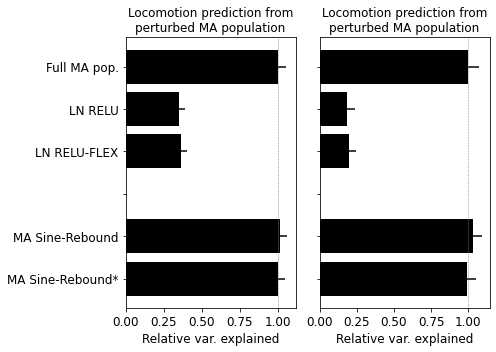

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), tight_layout=True, sharey=True)
for crslts, (ax, rslts) in enumerate(zip(axs, [rslts_1, rslts_60])):
    max_r2 = rslts[0][1]
    
    for crslt, (key, r2, err) in enumerate(rslts):
        ax.barh([-crslt], [r2/max_r2], xerr=[err/max_r2], color='k')
        
    ax.axvline(1, color='gray', ls='--', lw=.5)

    ax.set_yticks(-np.arange(len(rslts)))
    ax.set_yticklabels([rslt[0] for rslt in rslts])

    set_plot(ax, x_label='Relative var. explained', title='Locomotion prediction from\nperturbed MA population', font_size=12)
    
fig.savefig('supp/6_sine_rebound_fmtn_predictions.svg')